In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
## the objective of this file is to analyze the imact of scientific films on the society
## from previous models it is sure that the model is getting overfit
df = pd.read_csv('./data/final_annotations.csv')

df.drop(["sentiments", "impacts", "film_title", "batch"], axis = 1, inplace = True)

In [60]:
df.head()

,sentence,sentiment,impact
0,Good restraint on the use of adjectives.,Positive,Engagement with Film
1,Enjoy seeing/tracking storms....fascinating...,Positive,Interest with Science Topic
2,"The sound design, visuals and narration are bl...",Positive,Engagement with Film
3,Richard Dormer had a calming voice that made t...,Positive,Engagement with Film
4,So many never seen before images and actual pi...,Positive,Engagement with Film


In [61]:
df.drop_duplicates(inplace = True)

In [62]:
## lets make a model for sentiment analysis first using XGBoost and weight balancing

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from xgboost import XGBClassifier

X_1 = df.drop(["sentiment", "impact"], axis = 1)
y_1 = df["sentiment"]

In [63]:
y_1 = y_1.map({"Positive": 0, "Negative": 1, "Neutral": 2})

In [64]:
## using bag of words method to convert the text to vectors with stopwords removed and lemmitization
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    return [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

vectorizer = CountVectorizer(stop_words = stop_words, tokenizer = lemmatize_text)
X_1 = vectorizer.fit_transform(df["sentence"])

In [65]:

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_1),
                                        y = y_1                                                    
                                    )
class_weights = dict(zip(np.unique(y_1), class_weights))
class_weights

{0: 0.6312375249500998, 1: 1.1335125448028673, 2: 1.874074074074074}

In [66]:
## using stratify to make sure that the distribution of classes is same in train and test
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size = 0.2, stratify = y_1)

In [67]:
## looking at bag of words dictionary
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
X_test, y_test = smote.fit_resample(X_test, y_test)

## XGBoost Classifier

In [68]:
model1 = XGBClassifier()

model1.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [69]:
y_pred = model1.predict(X_train)

print("Accuracy on train set: ", accuracy_score(y_train, y_pred))

Accuracy on train set:  0.8478260869565217


In [70]:
print("Classification Report on train set: ", classification_report(y_train, y_pred))

Classification Report on train set:                precision    recall  f1-score   support

           0       0.97      0.79      0.87       534
           1       0.86      0.87      0.86       298
           2       0.64      0.98      0.77       180

    accuracy                           0.85      1012
   macro avg       0.82      0.88      0.84      1012
weighted avg       0.88      0.85      0.85      1012



<AxesSubplot: >

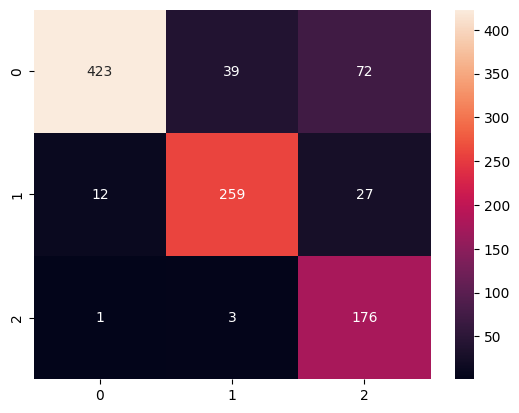

In [71]:
## plotting the confusion matrix

cm = confusion_matrix(y_train, y_pred)

sns.heatmap(cm, annot = True, fmt = "d")

Accuracy on test set:  0.5970149253731343
Classification Report on test set:                precision    recall  f1-score   support

           0       0.66      0.61      0.63       134
           1       0.62      0.50      0.55       134
           2       0.54      0.68      0.60       134

    accuracy                           0.60       402
   macro avg       0.60      0.60      0.60       402
weighted avg       0.60      0.60      0.60       402



<AxesSubplot: >

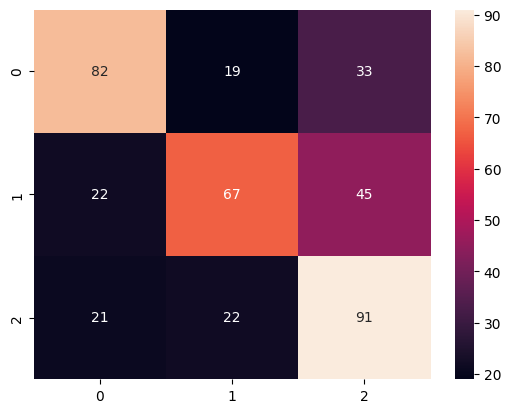

In [72]:
y_pred_test = model1.predict(X_test)

print("Accuracy on test set: ", accuracy_score(y_test, y_pred_test))

print("Classification Report on test set: ", classification_report(y_test, y_pred_test))

## plotting the confusion matrix

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot = True, fmt = "d")

In [73]:
df = df[df["impact"] != "TBD"]

df.dropna(inplace = True)

y = df["impact"]
X = df["sentence"]

y.value_counts()

Engagement with Film           768
Not applicable                 193
Shift in Knowledge             142
Interest with Science Topic     89
Impersonal Report               41
Name: impact, dtype: int64

In [74]:
X = vectorizer.transform(X)

In [75]:
y = y.map({"Engagement with Film": 0, "Not applicable": 1, "Shift in Knowledge": 2, "Interest with Science Topic":3, "Impersonal Report":4 })

In [76]:
y.value_counts()

0    768
1    193
2    142
3     89
4     41
Name: impact, dtype: int64

In [31]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y),
                                        y = y                                                    
                                    )
class_weights = dict(zip(np.unique(y), class_weights))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

model2 = XGBClassifier()

model2.fit(X_train, y_train, sample_weight = y_train.map(class_weights), eval_metric = "mlogloss", eval_set = [(X_test, y_test)])

[0]	validation_0-mlogloss:1.28284
[1]	validation_0-mlogloss:1.09362
[2]	validation_0-mlogloss:0.96805
[3]	validation_0-mlogloss:0.87763
[4]	validation_0-mlogloss:0.80522
[5]	validation_0-mlogloss:0.75497
[6]	validation_0-mlogloss:0.71294
[7]	validation_0-mlogloss:0.67983
[8]	validation_0-mlogloss:0.65283
[9]	validation_0-mlogloss:0.62814
[10]	validation_0-mlogloss:0.60756
[11]	validation_0-mlogloss:0.59449
[12]	validation_0-mlogloss:0.57912
[13]	validation_0-mlogloss:0.56674


/opt/homebrew/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-mlogloss:0.55852
[15]	validation_0-mlogloss:0.54777
[16]	validation_0-mlogloss:0.53798
[17]	validation_0-mlogloss:0.52920
[18]	validation_0-mlogloss:0.52219
[19]	validation_0-mlogloss:0.51621
[20]	validation_0-mlogloss:0.50997
[21]	validation_0-mlogloss:0.50580
[22]	validation_0-mlogloss:0.49869
[23]	validation_0-mlogloss:0.49472
[24]	validation_0-mlogloss:0.48881
[25]	validation_0-mlogloss:0.48439
[26]	validation_0-mlogloss:0.47979
[27]	validation_0-mlogloss:0.47403
[28]	validation_0-mlogloss:0.47161
[29]	validation_0-mlogloss:0.47024
[30]	validation_0-mlogloss:0.46754
[31]	validation_0-mlogloss:0.46415
[32]	validation_0-mlogloss:0.46095
[33]	validation_0-mlogloss:0.45701
[34]	validation_0-mlogloss:0.45419
[35]	validation_0-mlogloss:0.45113
[36]	validation_0-mlogloss:0.44936
[37]	validation_0-mlogloss:0.44636
[38]	validation_0-mlogloss:0.44416
[39]	validation_0-mlogloss:0.44321
[40]	validation_0-mlogloss:0.44128
[41]	validation_0-mlogloss:0.43937
[42]	validation_0-ml

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [40]:
y_pred = model2.predict(X_train)

print("Accuracy on train set: ", accuracy_score(y_train, y_pred))

Accuracy on train set:  0.9518229166666666


In [41]:

print("Classification Report on train set: \n", classification_report(y_train, y_pred))

Classification Report on train set: 
               precision    recall  f1-score   support

           0       0.94      0.85      0.89       614
           1       0.86      0.99      0.92       615
           2       0.98      0.96      0.97       614
           3       1.00      0.96      0.98       614
           4       1.00      1.00      1.00       615

    accuracy                           0.95      3072
   macro avg       0.95      0.95      0.95      3072
weighted avg       0.95      0.95      0.95      3072



<AxesSubplot: >

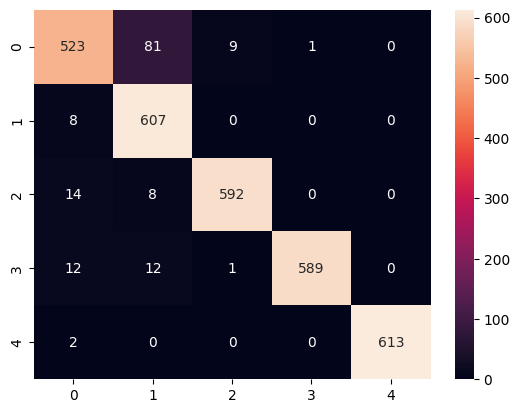

In [42]:
## plotting the confusion matrix
xm = confusion_matrix(y_train, y_pred)
sns.heatmap(xm, annot = True, fmt = "d")

In [43]:
y_pred = model2.predict(X_test)

print("Accuracy on test set: ", accuracy_score(y_test, y_pred))

Accuracy on test set:  0.8723958333333334


In [44]:
print("Classification Report on test set: \n", classification_report(y_test, y_pred))

Classification Report on test set: 
               precision    recall  f1-score   support

           0       0.77      0.73      0.75       154
           1       0.75      0.95      0.84       153
           2       0.94      0.84      0.89       154
           3       0.95      0.91      0.93       154
           4       0.99      0.93      0.96       153

    accuracy                           0.87       768
   macro avg       0.88      0.87      0.87       768
weighted avg       0.88      0.87      0.87       768



<AxesSubplot: >

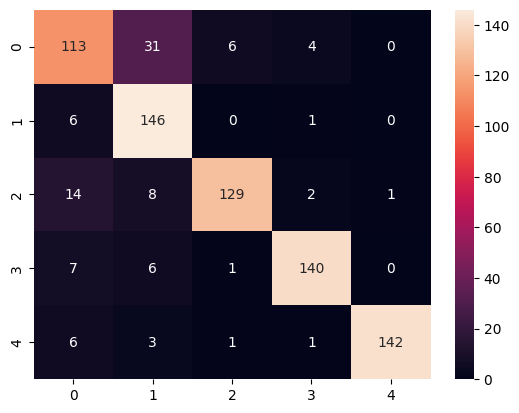

In [46]:
## plotting the confusion matrix
xm = confusion_matrix(y_test, y_pred)
sns.heatmap(xm, annot = True, fmt = "d")

1. Use new data.
2. Use smote for only the testing data.(if this can be done)
3. Stratified cross validation.

[0]	validation_0-mlogloss:1.27342
[1]	validation_0-mlogloss:1.09197
[2]	validation_0-mlogloss:0.96600
[3]	validation_0-mlogloss:0.87811
[4]	validation_0-mlogloss:0.80791
[5]	validation_0-mlogloss:0.75335
[6]	validation_0-mlogloss:0.70834
[7]	validation_0-mlogloss:0.67485
[8]	validation_0-mlogloss:0.64223
[9]	validation_0-mlogloss:0.61926
[10]	validation_0-mlogloss:0.59928
[11]	validation_0-mlogloss:0.58194
[12]	validation_0-mlogloss:0.56500
[13]	validation_0-mlogloss:0.55297
[14]	validation_0-mlogloss:0.54052
[15]	validation_0-mlogloss:0.52924
[16]	validation_0-mlogloss:0.52060
[17]	validation_0-mlogloss:0.51073
[18]	validation_0-mlogloss:0.50213
[19]	validation_0-mlogloss:0.49496
[20]	validation_0-mlogloss:0.49015
[21]	validation_0-mlogloss:0.48200
[22]	validation_0-mlogloss:0.47720
[23]	validation_0-mlogloss:0.47028
[24]	validation_0-mlogloss:0.46662
[25]	validation_0-mlogloss:0.46338
[26]	validation_0-mlogloss:0.45844
[27]	validation_0-mlogloss:0.45396
[28]	validation_0-mlogloss:0.4

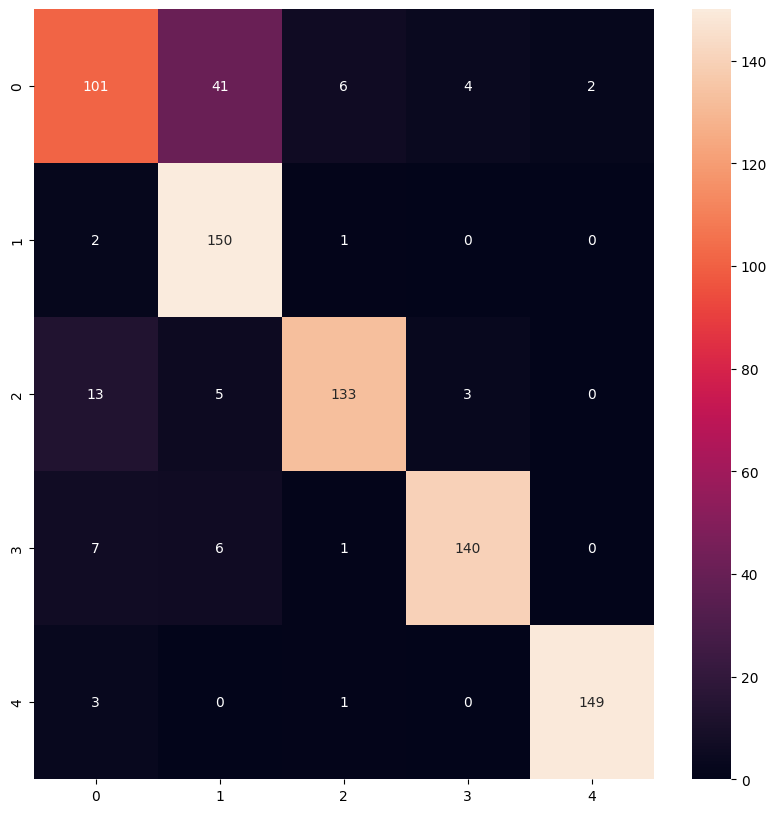



final accuracy:  0.8763020833333334
[0]	validation_0-mlogloss:1.26983
[1]	validation_0-mlogloss:1.08843
[2]	validation_0-mlogloss:0.96234
[3]	validation_0-mlogloss:0.87532
[4]	validation_0-mlogloss:0.80481
[5]	validation_0-mlogloss:0.75299
[6]	validation_0-mlogloss:0.71053
[7]	validation_0-mlogloss:0.67452
[8]	validation_0-mlogloss:0.64889
[9]	validation_0-mlogloss:0.62492
[10]	validation_0-mlogloss:0.60534
[11]	validation_0-mlogloss:0.58985
[12]	validation_0-mlogloss:0.57358
[13]	validation_0-mlogloss:0.56053
[14]	validation_0-mlogloss:0.54958
[15]	validation_0-mlogloss:0.53973
[16]	validation_0-mlogloss:0.53183
[17]	validation_0-mlogloss:0.52426
[18]	validation_0-mlogloss:0.51633
[19]	validation_0-mlogloss:0.50966
[20]	validation_0-mlogloss:0.50215
[21]	validation_0-mlogloss:0.49701
[22]	validation_0-mlogloss:0.49317
[23]	validation_0-mlogloss:0.48814
[24]	validation_0-mlogloss:0.48414
[25]	validation_0-mlogloss:0.47815
[26]	validation_0-mlogloss:0.47345
[27]	validation_0-mlogloss:

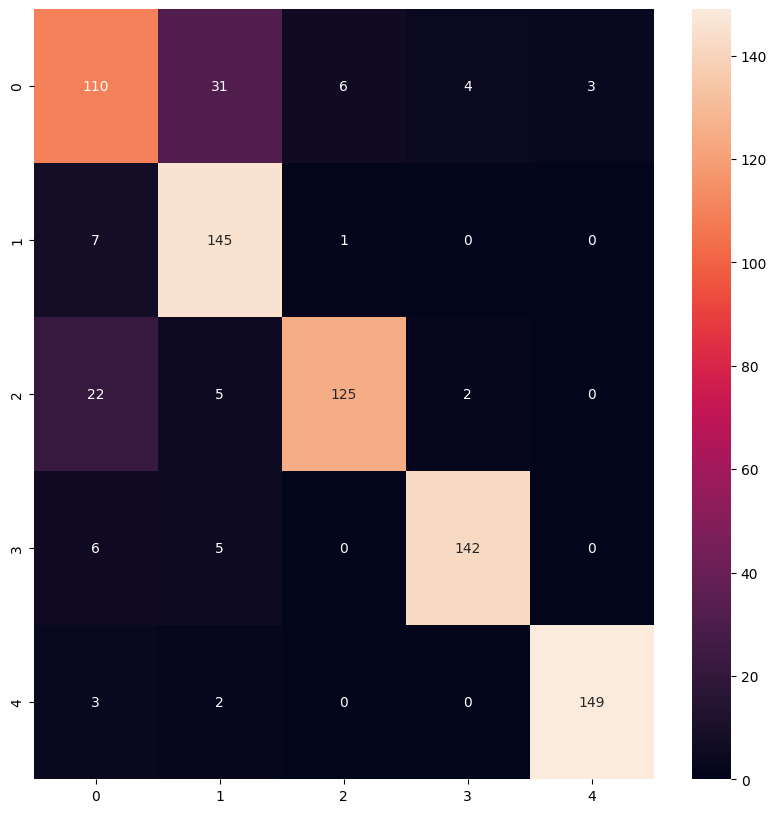



final accuracy:  0.8736979166666666
[0]	validation_0-mlogloss:1.26078
[1]	validation_0-mlogloss:1.06738
[2]	validation_0-mlogloss:0.93868
[3]	validation_0-mlogloss:0.84899
[4]	validation_0-mlogloss:0.78355
[5]	validation_0-mlogloss:0.72775
[6]	validation_0-mlogloss:0.68799
[7]	validation_0-mlogloss:0.65484
[8]	validation_0-mlogloss:0.62441
[9]	validation_0-mlogloss:0.59968
[10]	validation_0-mlogloss:0.57884
[11]	validation_0-mlogloss:0.56412
[12]	validation_0-mlogloss:0.55032
[13]	validation_0-mlogloss:0.53825
[14]	validation_0-mlogloss:0.52874
[15]	validation_0-mlogloss:0.52053
[16]	validation_0-mlogloss:0.51169
[17]	validation_0-mlogloss:0.50437
[18]	validation_0-mlogloss:0.49719
[19]	validation_0-mlogloss:0.48922
[20]	validation_0-mlogloss:0.48400
[21]	validation_0-mlogloss:0.47885
[22]	validation_0-mlogloss:0.47307
[23]	validation_0-mlogloss:0.46817
[24]	validation_0-mlogloss:0.46421
[25]	validation_0-mlogloss:0.45999
[26]	validation_0-mlogloss:0.45710
[27]	validation_0-mlogloss:

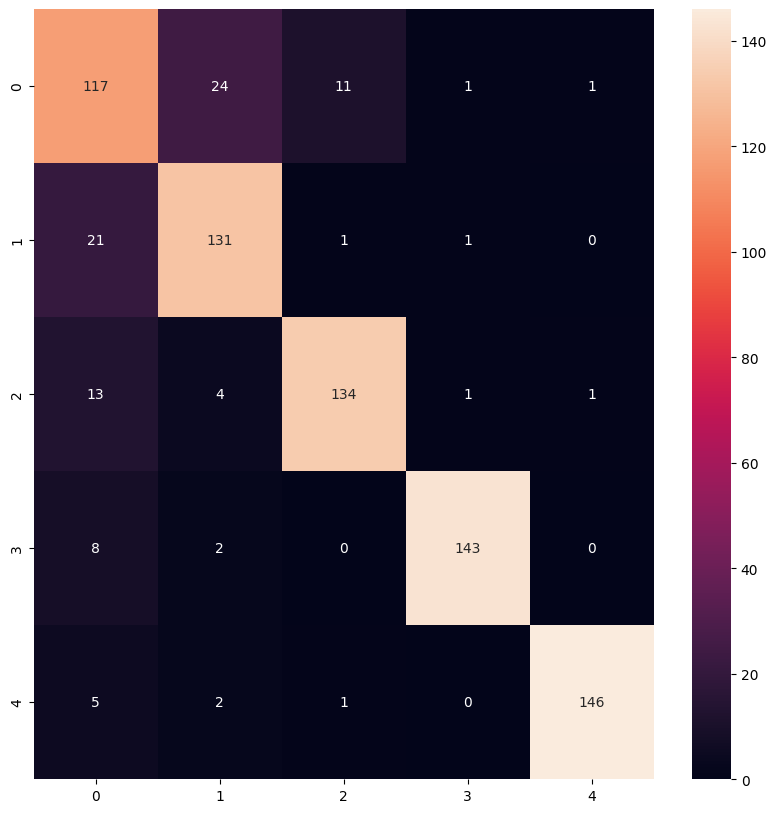



final accuracy:  0.8736979166666666
[0]	validation_0-mlogloss:1.27325
[1]	validation_0-mlogloss:1.09055
[2]	validation_0-mlogloss:0.95781
[3]	validation_0-mlogloss:0.86548
[4]	validation_0-mlogloss:0.79670
[5]	validation_0-mlogloss:0.74344
[6]	validation_0-mlogloss:0.69832
[7]	validation_0-mlogloss:0.66346
[8]	validation_0-mlogloss:0.63660
[9]	validation_0-mlogloss:0.61382
[10]	validation_0-mlogloss:0.59204
[11]	validation_0-mlogloss:0.57454
[12]	validation_0-mlogloss:0.55969
[13]	validation_0-mlogloss:0.54478
[14]	validation_0-mlogloss:0.53430
[15]	validation_0-mlogloss:0.52352
[16]	validation_0-mlogloss:0.51528
[17]	validation_0-mlogloss:0.50737
[18]	validation_0-mlogloss:0.49872
[19]	validation_0-mlogloss:0.49127
[20]	validation_0-mlogloss:0.48568
[21]	validation_0-mlogloss:0.47861
[22]	validation_0-mlogloss:0.47264
[23]	validation_0-mlogloss:0.46790
[24]	validation_0-mlogloss:0.46283
[25]	validation_0-mlogloss:0.45832
[26]	validation_0-mlogloss:0.45498
[27]	validation_0-mlogloss:

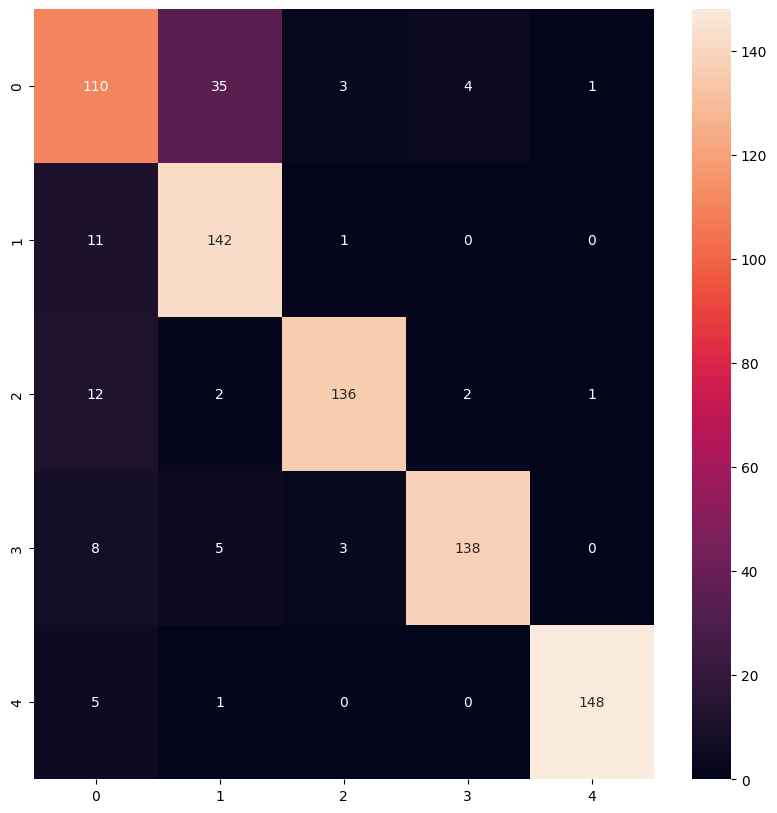



final accuracy:  0.8776041666666666
[0]	validation_0-mlogloss:1.26663
[1]	validation_0-mlogloss:1.07636
[2]	validation_0-mlogloss:0.94974
[3]	validation_0-mlogloss:0.85306
[4]	validation_0-mlogloss:0.78295
[5]	validation_0-mlogloss:0.72450
[6]	validation_0-mlogloss:0.67949
[7]	validation_0-mlogloss:0.64463
[8]	validation_0-mlogloss:0.61373
[9]	validation_0-mlogloss:0.58881
[10]	validation_0-mlogloss:0.56994
[11]	validation_0-mlogloss:0.55243
[12]	validation_0-mlogloss:0.53748
[13]	validation_0-mlogloss:0.52853
[14]	validation_0-mlogloss:0.51661
[15]	validation_0-mlogloss:0.50518
[16]	validation_0-mlogloss:0.49825
[17]	validation_0-mlogloss:0.48974
[18]	validation_0-mlogloss:0.48427
[19]	validation_0-mlogloss:0.47769
[20]	validation_0-mlogloss:0.47007
[21]	validation_0-mlogloss:0.46452
[22]	validation_0-mlogloss:0.45924
[23]	validation_0-mlogloss:0.45221
[24]	validation_0-mlogloss:0.44847
[25]	validation_0-mlogloss:0.44388
[26]	validation_0-mlogloss:0.43965
[27]	validation_0-mlogloss:

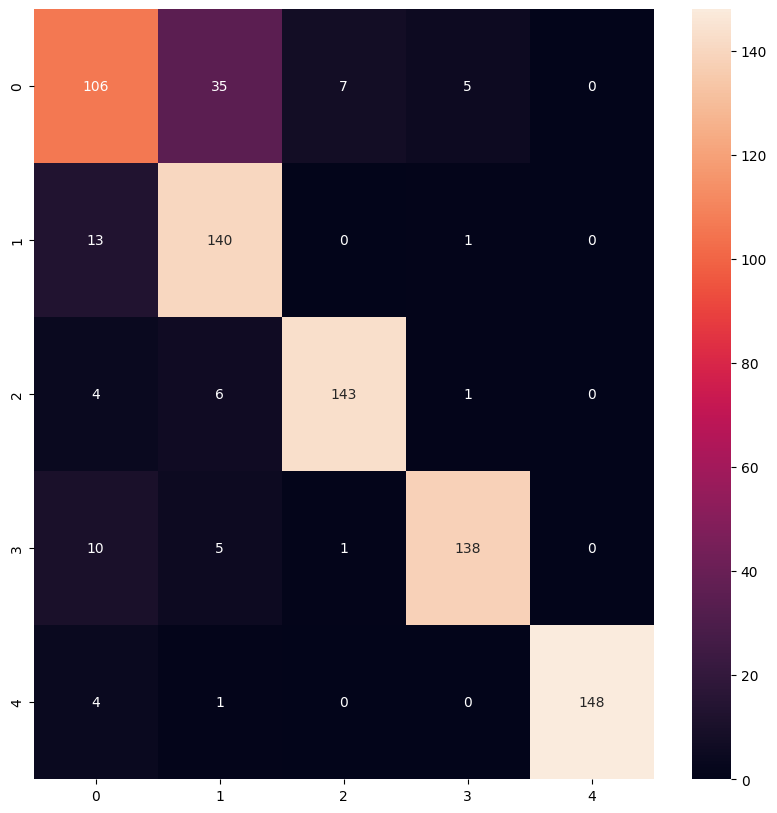



final accuracy:  0.87890625


In [49]:
## using stratified cross validation for better results on XGBoost model

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model2.fit(X_train, y_train, sample_weight = y_train.map(class_weights), eval_set = [(X_test, y_test)])
    
    y_pred = model2.predict(X_test)
    
    print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
    
    print("Classification Report on test set: \n", classification_report(y_test, y_pred))

    ## plotting the confusion matrix
    xm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (10, 10))
    sns.heatmap(xm, annot = True, fmt = "d")
    plt.show()
    
    print("\n")

    print("final accuracy: ", accuracy_score(y_test, y_pred))
    

In [57]:
## using the trained model to predict the impact of a sentence

def predict_impact(sentence):
    sentence = vectorizer.transform([sentence])
    impact = model2.predict(sentence)
    return impact

predict_impact("are you interested in science? you should watch this movie")

array([0])